# Summary:
__Motivation for using jerk__: So the previous notebooks analyzed variability across multiple curves throughout a day's session. The variability within a single trial, however, is impossible to calculate without making assumptions about the hidden deterministic curve. I originally wanted to try to fit some class of deterministic function to the movements (and then do, for example, a Kalman filter to figure out the exact hidden parameters/function for each movement curve and subtract this to find variability), but later realized that the entire class of target movements the mice are actually aiming for internally might still be completely different between WT and diseased models.

The smoothest movement between point A and point B will be the movement trajectory that minimizes jerk, the third derivative of position, between these two points. As it turns out, for animal movements, this minimal jerk trajectory is also the one expert animals (practiced adult WT humans) will perform for maximum motor efficiency [(Todorov and Jordan 1998)](doi.org/10.1152/jn.1998.80.2.696).

Therefore, as a measure of smoothness across a single movement curve, I want to calculate the jerk across the entire movement. Of course, the cumulative jerk squared (squared to ignore changes in sign) across an entire movement will depend on the time it takes to do the movement (speed) and initial acceleration. Therefore, I will normalize the cumulative jerk calculated by the cumulative jerk from an ideal most efficient trajectory that minimizes jerk. Specifically, I want to calculate $\frac{\int j(t)^2dt}{\int j_\text{min}(t)^2dt}$ were $j(t)$ is the jerk across the movement and $j_\text{min}(t)$ is the ideal smoothest minimal jerk. 

__On finding the ideal smoothest minimal jerk, from [Todorov and Jordan 1998](doi.org/10.1152/jn.1998.80.2.696)__: _It has been shown (Flash and Hogan 1985) that for given passage times T, positions x, velocities ν, and accelerations a at the end points of one segment, the minimum-jerk trajectory is a 5th-order polynomial in t, the coefficients of which can be determined easily using the end-point constraints. It is then possible to integrate the squared jerk analytically, and sum it over all segments._

So if I'm understanding that correctly,
$x_\text{min}(t)=C_1 t^5 + C_2 t^4 + C_3 t^3 + C_4 t^2 + C_5 t + C_6$

with boundary conditions:
1) $x(0)=x_0$
2) $v(0)=v_0$
3) $a(0)=a_0$ and 
4) $x(t_f)=x_f$
5) $v(t_f)=v_f$
6) $a(t_f)=a_f$

where $t_f$ is the end/final time of the movement when point B is reached.

Then after the constants are solved for,
$j_\text{min}(t)=x_\text{min}'''(t)$


### imports

In [1]:
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import statistics
import pandas as pd

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lombscargle.html
import scipy.signal as signal

# interpolation because ARDUINO data is spaced unevenly
import scipy.interpolate as interpolate

import pickle # save data
import glob # find files in a directory
import re # regex for string parsing

### set `folder_name`

In [2]:
# for all .mat files in this folder starting with "ToneDisc_ANChandler_p1_" in their name
folder_name = './Joey/Phase1/ToneDisc_ANJoey_p1_'

### sort through relevant .mat files found in folder by day ("_d#")

In [3]:
unsorted_mat_files = glob.glob(folder_name+'*.mat')
sorted_mat_files = sorted(unsorted_mat_files, key=lambda x: int(re.search(r'\d+.mat$',x).group()[:-4]))
sorted_mat_files

['./Joey/Phase1/ToneDisc_ANJoey_p1_d1.mat',
 './Joey/Phase1/ToneDisc_ANJoey_p1_d2.mat',
 './Joey/Phase1/ToneDisc_ANJoey_p1_d3.mat',
 './Joey/Phase1/ToneDisc_ANJoey_p1_d4.mat',
 './Joey/Phase1/ToneDisc_ANJoey_p1_d5.mat',
 './Joey/Phase1/ToneDisc_ANJoey_p1_d6.mat',
 './Joey/Phase1/ToneDisc_ANJoey_p1_d7.mat',
 './Joey/Phase1/ToneDisc_ANJoey_p1_d8.mat',
 './Joey/Phase1/ToneDisc_ANJoey_p1_d9.mat',
 './Joey/Phase1/ToneDisc_ANJoey_p1_d10.mat',
 './Joey/Phase1/ToneDisc_ANJoey_p1_d11.mat',
 './Joey/Phase1/ToneDisc_ANJoey_p1_d12.mat',
 './Joey/Phase1/ToneDisc_ANJoey_p1_d13.mat',
 './Joey/Phase1/ToneDisc_ANJoey_p1_d14.mat']

### pick a day and extract data from .mat

In [20]:
mat_file = sorted_mat_files[-1]
file = open(mat_file+'_movements_dataArduino.pickle', 'rb')
movements_dataArduino = pickle.load(file)
file.close()

### calculate the third derivative (jerk)

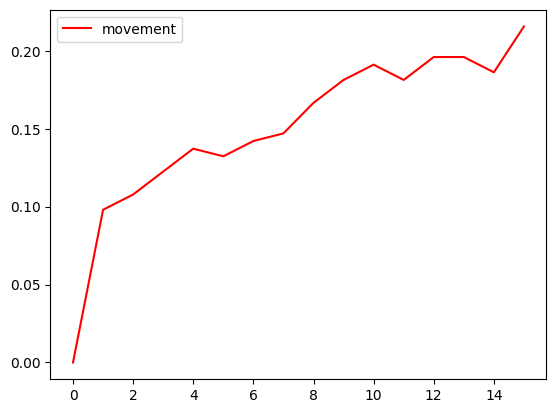

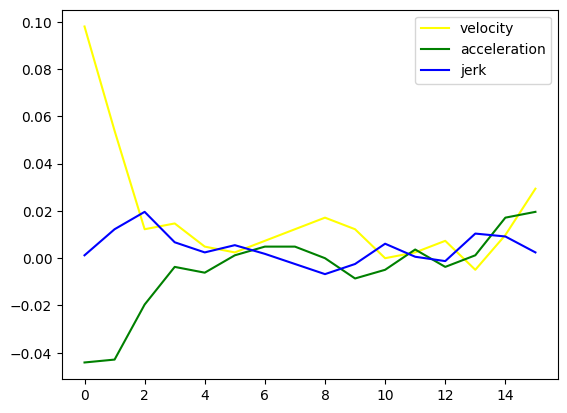

In [23]:
movement_dataArduino = np.abs(movements_dataArduino[0][1])
num_arduino_samples = len(movements_dataArduino[0][1])
plt.plot(range(num_arduino_samples), movement_dataArduino, color='red', label='movement')
plt.legend()
plt.show()

dydx = np.gradient(movement_dataArduino, 1)
plt.plot(range(num_arduino_samples), dydx, color='yellow', label='velocity')
d2ydx2 = np.gradient(dydx, 1)
plt.plot(range(num_arduino_samples), d2ydx2, color='green', label='acceleration')
d3ydx3 = np.gradient(d2ydx2, 1)
plt.plot(range(num_arduino_samples), d3ydx3, color='blue', label='jerk')
plt.legend()
plt.show()

### normalize by the minimum jerk trajectory between two motion states